## Importing dataset and visualization

In [1]:
import PRF
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath('../../'))
from utils import load_keel_dataset

file_path_train="../keel_data/pima-20cn01-nc-5-1tra.dat"
file_path_test="../keel_data/pima-20cn01-nc-5-1tst.dat"


X_train, X_test, y_train, y_test, label_map = load_keel_dataset(
    train_path=file_path_train,
    test_path=file_path_test,
    already_split=True
)
print("Head of training data: \n", X_train[:5])
print("Head of labels: \n", y_train[:5])

Head of training data: 
 [[4.000e+00 1.460e+02 7.800e+01 0.000e+00 0.000e+00 3.850e+01 5.200e-01
  6.700e+01]
 [1.500e+01 1.360e+02 7.000e+01 3.200e+01 1.100e+02 3.710e+01 1.530e-01
  4.300e+01]
 [1.000e+01 1.010e+02 8.600e+01 3.700e+01 0.000e+00 4.560e+01 1.136e+00
  3.800e+01]
 [1.000e+00 1.680e+02 8.800e+01 2.900e+01 0.000e+00 3.500e+01 9.050e-01
  5.200e+01]
 [5.000e+00 9.600e+01 7.400e+01 1.800e+01 6.700e+01 3.360e+01 9.970e-01
  4.300e+01]]
Head of labels: 
 [2 2 2 2 1]


#### Visualization

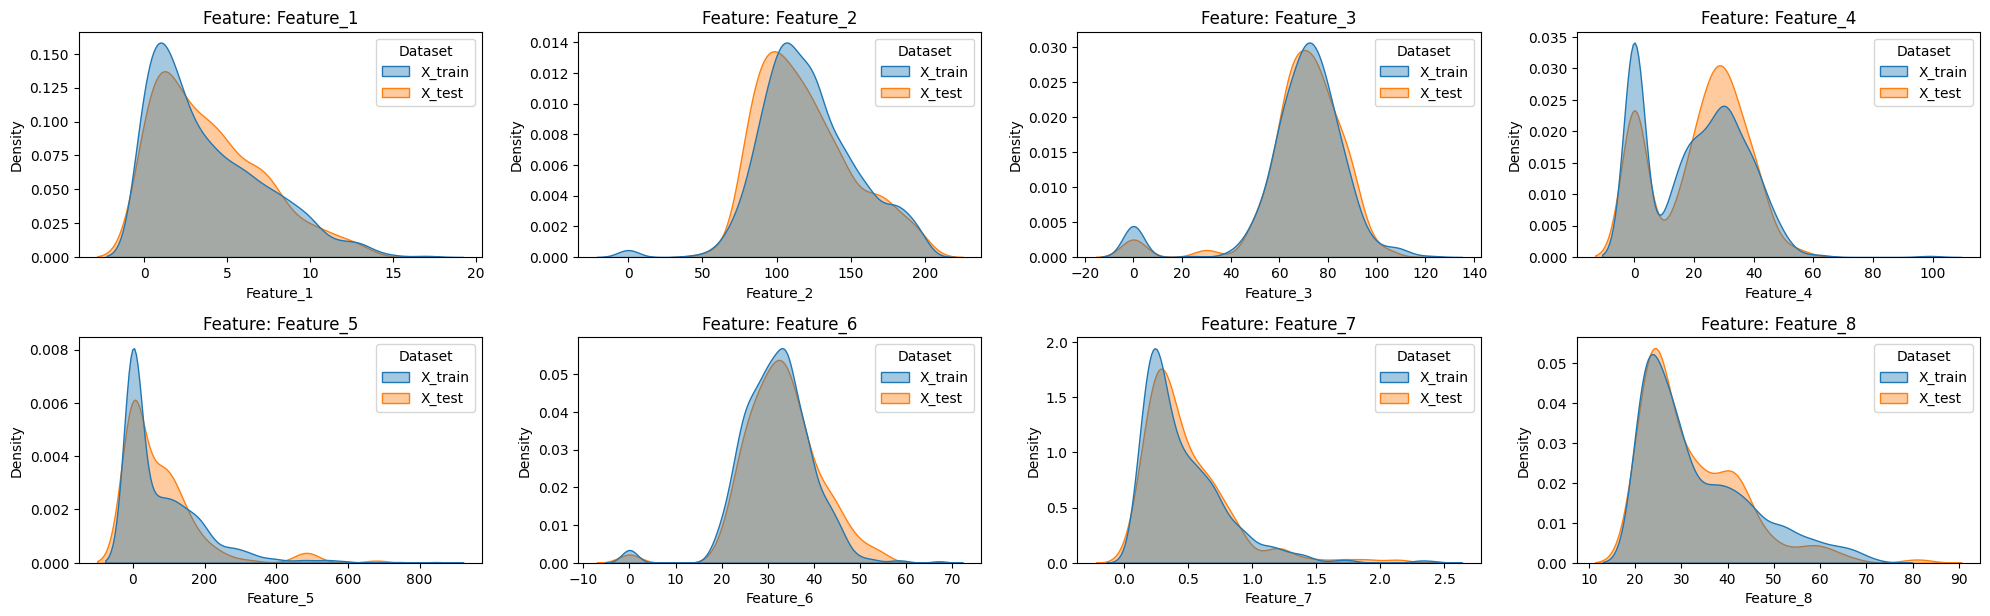

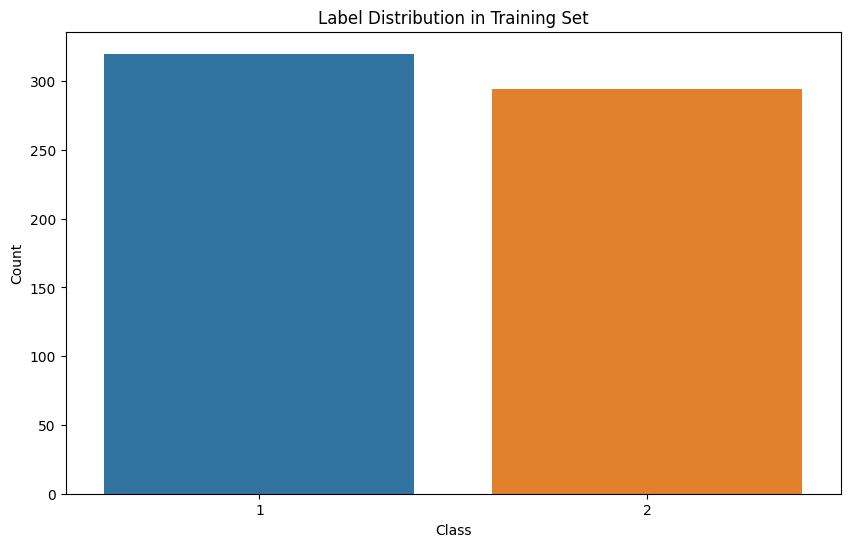

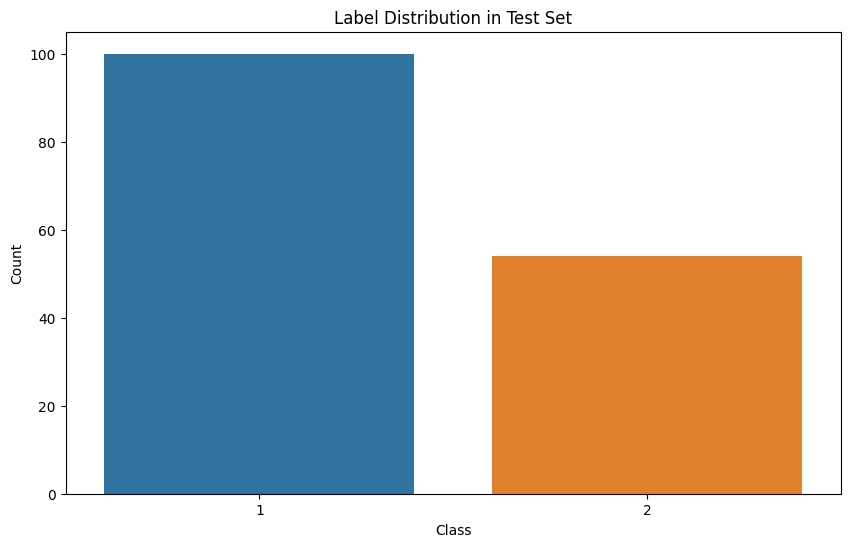

In [2]:
feature_names_train = [f'Feature_{i+1}' for i in range(X_train.shape[1])]

df1 = pd.DataFrame(X_train, columns=feature_names_train)
df1['Label'] = y_train
df1['Dataset'] = 'X_train'

feature_names_test = [f'Feature_{i+1}' for i in range(X_test.shape[1])]

df2 = pd.DataFrame(X_test, columns=feature_names_test)
df2['Label'] = y_test       # <-- Fix here: assign y_test to df2, not df1
df2['Dataset'] = 'X_test'

# Combine both train and test dataframes for plotting
df_all = pd.concat([df1, df2], ignore_index=True)

# Plot distributions of each feature side by side
plt.figure(figsize=(20, 15))
for i, feature in enumerate(feature_names_train):
    plt.subplot(5, 4, i + 1)
    sns.kdeplot(data=df_all, x=feature, hue='Dataset', common_norm=False, fill=True, alpha=0.4, bw_adjust=0.8)
    plt.title(f"Feature: {feature}")
plt.tight_layout()
plt.show()



# Plot label distribution (only for training set or combined if you want)
plt.figure(figsize=(10, 6))
sns.countplot(x='Label', data=df1, order=sorted(df1['Label'].unique()))
plt.title("Label Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Label', data=df2, order=sorted(df2['Label'].unique()))
plt.title("Label Distribution in Test Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


#### Adding noise

In [10]:
# NOTE: THIS CODE MAKES LITTLE SENSE IF THERE ARE BOUNDS IN AN INTERVAL OF A FEATURE (LIKE IT HAS TO BE BETWEEN 0 AND 1)


from utils import add_noise

X_train_noisy, _, dX, _ = add_noise(X_train, noise_type='gaussian_heteroschedastic', gaussian_scale=0.6)
# Printing noise head (dX):
print("Head of noise (dX): \n", dX[:5])

NameError: name 'Xtrain' is not defined

In [ ]:
# TODO: Noise for labels (?), other types of noise

#### Visualizing noise

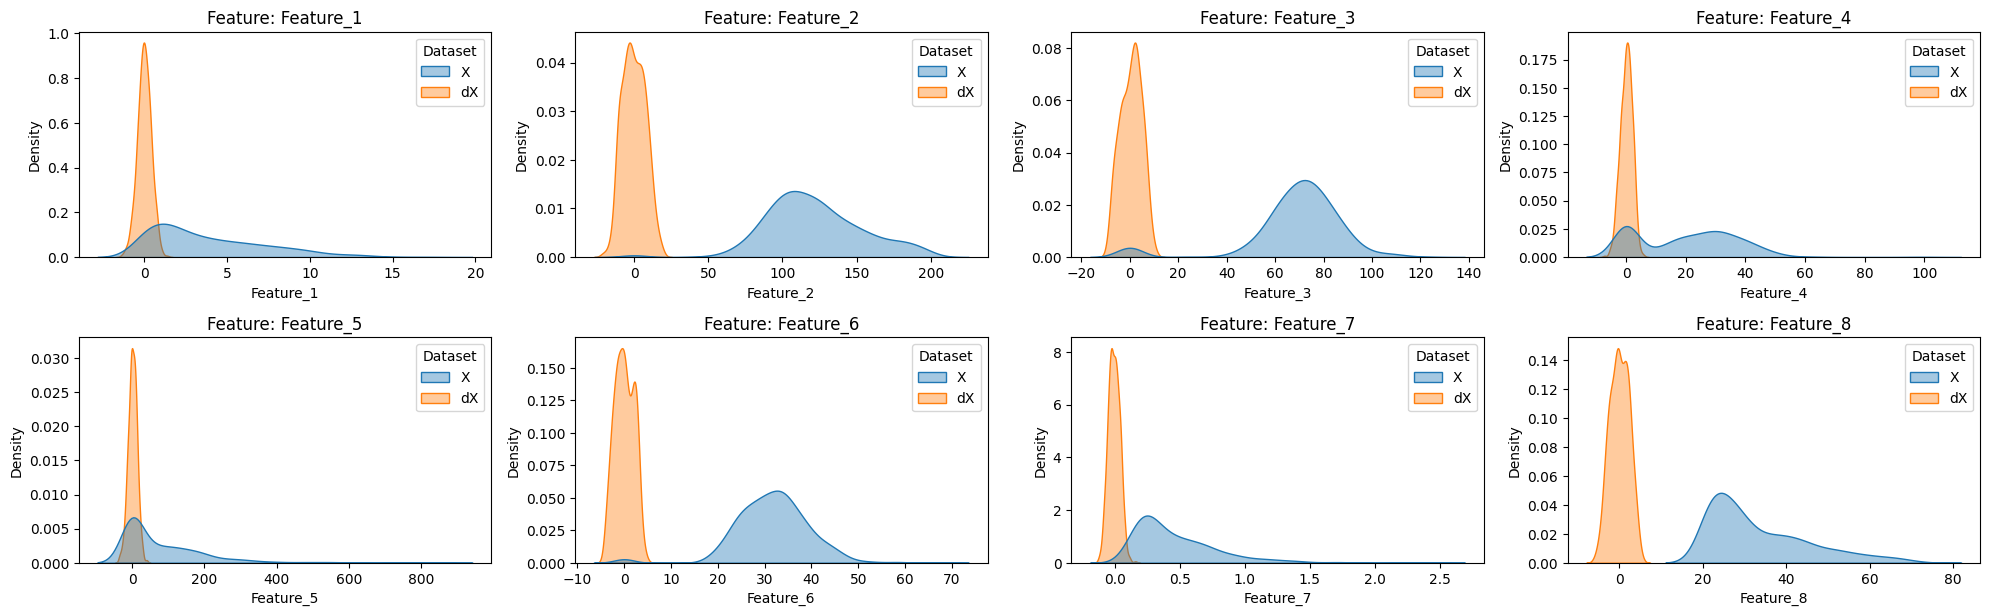

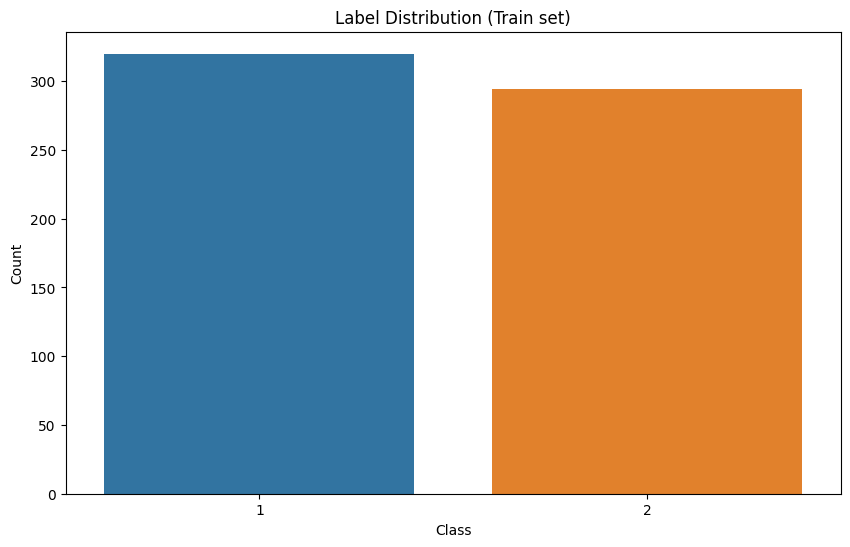

In [4]:
feature_names = [f'Feature_{i+1}' for i in range(X_train.shape[1])]

df1 = pd.DataFrame(X_train, columns=feature_names)
df1['Label'] = y_train
df1['Dataset'] = 'X'

df2 = pd.DataFrame(dX, columns=feature_names)
df2['Dataset'] = 'dX'

# Combine both for easier plotting
df_all = pd.concat([df1, df2], ignore_index=True)

# Plot distributions of each feature side by side
plt.figure(figsize=(20, 15))
for i, feature in enumerate(feature_names):
    plt.subplot(5, 4, i + 1)
    sns.kdeplot(data=df_all, x=feature, hue='Dataset', common_norm=False, fill=True, alpha=0.4)
    plt.title(f"Feature: {feature}")
plt.tight_layout()
plt.show()

# Plot label distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Label', data=df1, order=sorted(df1['Label'].unique()))
plt.title("Label Distribution (Train set)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

## PDRF

In [5]:
# TODO: Use the PDRF algorithm

accuracy_PDRF = 1.0 # Placeholder for the actual accuracy 

## Other methods for classification

#### Probabilistic Random Forest

In [6]:
n_trees = 10
prf_cls = PRF.prf(n_estimators=n_trees,  bootstrap=True)
prf_cls.fit(X=X_train_noisy, y=y_train, dX=dX)
score = prf_cls.score(X_test, y=y_test)
print('PRF Score: ', score)

#Score is defined like this, so same as accuracy

'''def score(self, X, y, dX=None):
        y_pred = self.predict(X, dX)
        score = (y_pred == (y)).sum()/len(y)
        return score''' 

accuracy_PRF = score

PRF Score:  0.7272727272727273


#### Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier(n_estimators=20, random_state=27)
# Fit the model
rf.fit(X_train_noisy, y_train)

# Predict on test data
y_pred = rf.predict(X_test)

accuracy_RF = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_RF:.4f}")

Accuracy: 0.8247


#### Deep Forest

In [8]:
from deepforest import CascadeForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Set random_state for reproducibility
clf = CascadeForestClassifier(n_estimators=2, random_state=27)  # 2 estimators per layer by default

# Fit the model
clf.fit(X_train_noisy, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
accuracy_DF = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_DF:.4f}")
print(classification_report(y_test, y_pred))

[2025-06-04 09:21:24.770] Start to fit the model:
[2025-06-04 09:21:24.771] Fitting cascade layer = 0 
[2025-06-04 09:21:25.166] layer = 0  | Val Acc = 66.124 % | Elapsed = 0.395 s
[2025-06-04 09:21:25.170] Fitting cascade layer = 1 
[2025-06-04 09:21:25.790] layer = 1  | Val Acc = 67.590 % | Elapsed = 0.619 s
[2025-06-04 09:21:25.796] Fitting cascade layer = 2 
[2025-06-04 09:21:26.440] layer = 2  | Val Acc = 64.658 % | Elapsed = 0.644 s
[2025-06-04 09:21:26.441] Early stopping counter: 1 out of 2
[2025-06-04 09:21:26.449] Fitting cascade layer = 3 
[2025-06-04 09:21:27.116] layer = 3  | Val Acc = 64.495 % | Elapsed = 0.667 s
[2025-06-04 09:21:27.117] Early stopping counter: 2 out of 2
[2025-06-04 09:21:27.117] Handling early stopping
[2025-06-04 09:21:27.117] The optimal number of layers: 2
[2025-06-04 09:21:27.118] Start to evalute the model:
[2025-06-04 09:21:27.118] Evaluating cascade layer = 0 
[2025-06-04 09:21:27.129] Evaluating cascade layer = 1 
Accuracy: 0.7532
             

#### Neural Network

In [9]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import os

# Disable GPU (otherwise my PC explodes for some reason)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
np.random.seed(27)
tf.random.set_seed(27)

# Detect classification type
unique_classes = np.unique(y_train)
num_classes = len(unique_classes)
is_binary = num_classes == 2

# One-hot encode labels if multiclass
if not is_binary:
    y_train_cat = to_categorical(np.searchsorted(unique_classes, y_train))
    y_test_cat = to_categorical(np.searchsorted(unique_classes, y_test))
else:
    y_train_cat = y_train
    y_test_cat = y_test

# Define the model builder function
def create_model(hidden_units=32, dropout_rate=0.5, optimizer='adam'):
    model = Sequential()
    model.add(Dense(hidden_units, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dropout(dropout_rate))
    if is_binary:
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    else:
        model.add(Dense(num_classes, activation='softmax'))
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Wrap with SciKeras
model = KerasClassifier(model=create_model, verbose=0)

# Grid search parameters
param_grid = {
    'model__hidden_units': [32, 64],
    'model__dropout_rate': [0.3, 0.5],
    'model__optimizer': ['adam'],
    'batch_size': [16],
    'epochs': [20]
}

# Grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=1)
grid_result = grid.fit(X_train_noisy, y_train_cat)

# Evaluate the best model
best_model = grid_result.best_estimator_

if is_binary:
    y_pred = best_model.predict(X_test)
    y_test_true = y_test
else:
    y_pred_proba = best_model.predict_proba(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_test_true = np.searchsorted(unique_classes, y_test)

# Output results
accuracy_NN = accuracy_score(y_test_true, y_pred)
print("Best params:", grid_result.best_params_)
print(f"Accuracy: {accuracy_NN:.4f}")
print(classification_report(y_test_true, y_pred, digits=4))


2025-06-04 11:21:30.265614: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-04 11:21:30.456108: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-04 11:21:30.468874: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/gurobi1102/win64/lib:/usr/local/gurobi1102/win64/lib
2025-06-04 11:21:30.468899: I

Best params: {'batch_size': 16, 'epochs': 20, 'model__dropout_rate': 0.5, 'model__hidden_units': 32, 'model__optimizer': 'adam'}
Accuracy: 0.6818
              precision    recall  f1-score   support

           1     0.7429    0.7800    0.7610       100
           2     0.5510    0.5000    0.5243        54

    accuracy                         0.6818       154
   macro avg     0.6469    0.6400    0.6426       154
weighted avg     0.6756    0.6818    0.6780       154



#### Bayesian Logistic Regression (??)

#### Kernel SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# 1. Define the model
svm_model = SVC()

# 2. Define hyperparameter grid
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.01, 0.1, 1, 10],
    'gamma': ['scale', 'auto']  
}

# 3. Grid search with cross-validation
grid = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_result = grid.fit(X_train_noisy, y_train)

# 4. Predict with best model
best_svm = grid_result.best_estimator_
y_pred = best_svm.predict(X_test)

# 5. Report
accuracy_KSVM = accuracy_score(y_test, y_pred)
print("Best params:", grid_result.best_params_)
print(f"Accuracy: {accuracy_KSVM:.4f}")
print(classification_report(y_test, y_pred))


Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 0.6061
              precision    recall  f1-score   support

           1       0.50      0.75      0.60        93
           2       1.00      1.00      1.00         1
           3       0.62      0.71      0.67         7
           4       0.75      0.75      0.75         8
           5       0.70      0.64      0.67        11
           6       0.79      0.84      0.82        32
           7       0.69      0.45      0.54        49
           8       0.66      0.45      0.54        86
           9       0.75      0.75      0.75         4
          10       0.00      0.00      0.00         6

    accuracy                           0.61       297
   macro avg       0.65      0.63      0.63       297
weighted avg       0.62      0.61      0.59       297



/home/fabyk/PROJECT_PML/PML/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fabyk/PROJECT_PML/PML/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fabyk/PROJECT_PML/PML/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Results Comparison

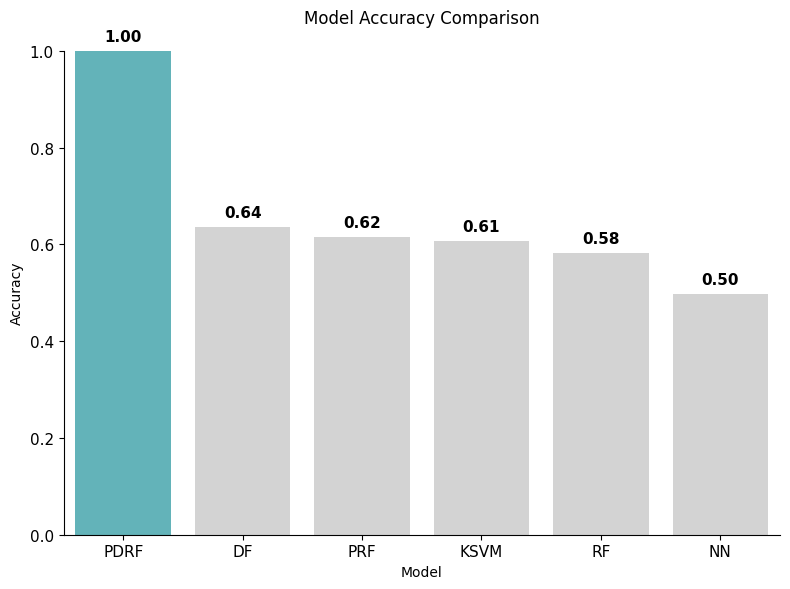

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare data
data = {
    'Model': ['PRF', 'PDRF', 'NN', 'KSVM', 'DF','RF'],
    'Accuracy': [accuracy_PRF, accuracy_PDRF, accuracy_NN, accuracy_KSVM, accuracy_DF, accuracy_RF]
}

df = pd.DataFrame(data)

# Sort by Accuracy descending
df = df.sort_values('Accuracy', ascending=False)

# Define colors based on your request
def get_color(model):
    if model == 'PDRF':
        return '#55bfc7'
    elif model in ['PRF', 'DF']:
        return 'lightgray'
    else:
        return 'lightgray'

colors = df['Model'].apply(get_color)

plt.figure(figsize=(8,6))
ax = sns.barplot(x='Model', y='Accuracy', data=df, palette=colors)

# Remove top and right spines
sns.despine()

# Add space between title and plot
plt.title('Model Accuracy Comparison', pad=20)

# Set labels and limits
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xlabel('Model')

# Set tick font size
ax.tick_params(axis='both', labelsize=11)

# Add accuracy values on top of each bar, bold
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=11, fontweight='bold', color='black',
                xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()



#### Saving results

In [ ]:
import os
from pathlib import Path

# 1. Extract filename base: last part after `/`, before `.`, remove "tra" if present
filename = Path(file_path_train).name  # 'my_dataset_tra.csv'
basename = filename.rsplit('.', 1)[0].replace('tra', '')  # 'my_dataset_'

# 2. Create output folder one level up
output_dir = Path(file_path_train).parent.parent / 'accuracy_scores'
output_dir.mkdir(parents=True, exist_ok=True)

# 3. Save the dataframe
output_path = output_dir / f'{basename}_noisy.csv'
df.to_csv(output_path, index=False)

print(f"Accuracy data saved to: {output_path}")


Accuracy data saved to: ../accuracy_scores/yeast-5-1_noisy.csv
